# [IAPR][iapr]: Final project - Chocolate Recognition


**Moodle group ID:** *47*  
**Kaggle challenge:** *Deep learning*
**Kaggle team name (exact):** "*Group47-ChocoKiffeur*"  

**Author 1 (SCIPER):** *Lucas Maneff 1 (324 942)*  
**Author 2 (SCIPER):** *Jérémy Hugentobler (341 467)*  
  

**Due date:** 21.05.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`
- **Only groups of three will be accepted**, except in exceptional circumstances.


[iapr]: https://github.com/LTS5/iapr2025

---

In [1]:
import torch

# Data 

In this first part, we will describe our journey with the dataset needed to train our deep learning model.

## The initial dataset

The provided dataset contains images of 13 different kinds of chocolates, placed on various backgrounds where some adversarial objects are also present (round shapes, gloves, ...)

From the presentation slide, we know that *"All photos were taken under the same conditions — using the same camera, at the same distance, and with the same resolution."*, Which means that all the chocolate will be **similar in size** in each picture and that the amount of "challenges" that we have to prepare for is limited.

Initially, the training dataset contains 90 images, which is not a lot considering that we need to train a DL model from scratch. Additionaly, we took the liberty of adding the 13 reference images in the train dataset, thus obtaining a total of 103 images to train from.


## Data-augmentation

Knowing that the provided data is limited, we had to think about different methods that would allow our model to train from additional data samples and we used two techniques that we combined together: **Synthetic data creation** and **image transformations**.

### Synthetic data

The goal is to create new synthetic images based on content extracted from the existing ones. The first step was to isolate each chocolate from a background, which gave the following results:
<img src="data/alpha_references/jelly_black.png" alt="Jelly Black" width="200"/>
<img src="data/alpha_references/arabia.png" alt="Arabia" width="200"/>
<img src="data/alpha_references/tentation_noir.png" alt="Tentation noir" width="200"/>


This was done manually on gimp and is quite a long task, but once we had those 13 isolated samples, we wrote a script that applies a random rotation, and optionally a random noise to each chocolate and place them on a background. The number of chocolate varies between 1 and 3 and is picked at random. 

Here is an example on a black background:

Associated label: {'Jelly White': 0, 'Jelly Milk': 0, 'Jelly Black': 0, 'Amandina': 0, 'Crème brulée': 0, 'Triangolo': 1, 'Tentation noir': 1, 'Comtesse': 0, 'Noblesse': 0, 'Noir authentique': 0, 'Passion au lait': 1, 'Arabia': 0, 'Stracciatella': 0}


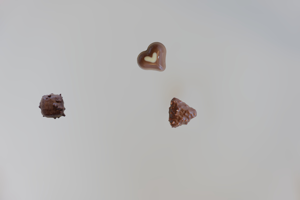

In [2]:
from src.data.synthetic_data_generation import generate_synthetic_image
from PIL import Image
background = Image.open("data/backgrounds/blank_bg1.JPG")
img, label = generate_synthetic_image(background, "data/alpha_references/", (4000, 6000), noise=True)
print("Associated label:", label)
img.resize((300, 200)) # resize for rapport visualization

Additional Associated label: {'Jelly White': 0, 'Jelly Milk': 0, 'Jelly Black': 0, 'Amandina': 0, 'Crème brulée': 0, 'Triangolo': 0, 'Tentation noir': 0, 'Comtesse': 0, 'Noblesse': 0, 'Noir authentique': 0, 'Passion au lait': 0, 'Arabia': 1, 'Stracciatella': 0}


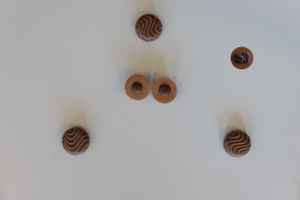

In [14]:
# On an image without a blank background
from src.data.synthetic_data_generation import generate_synthetic_image
from PIL import Image
background = Image.open("data/train/L1000792.JPG")
img, label = generate_synthetic_image(background, "data/alpha_references/", (4000, 6000), noise=True)
print("Additional Associated label:", label)
img.resize((300, 200)) # resize for rapport visualization

We first used a static approach, where we would generate each synthetic images ahead of time, but this process is quite cumbersome (ie. moving all your images to Google Colab at every modification), so we instead incorporated it directly into a torch Dataset that applies this augmentation when giving in an image.

You can see this dataset implementation in the [SyntheticChocolateDataset.py](src/data/SyntheticChocolateDataset.py) file (*datasets are in src/data*).

This dataset is then merged with a standard training dataset from [TrainChocolateDataset.py](src/data/TrainChocolateDataset.py) that contains the inital data. (This dataset)

> ⚠️ We also separate the training set in two part for validation purposes, so the merging happens only with the training part, therefore our validation set remains pure of such synthetic images. 

### Dataset transformation

Torch allows us to define sequence of operation to apply on our images when they are fetched from their respective pytorch Datasets.
We defined two different transformations, one for the training (including synthetic images), one for the validation and test sets.

Our training tranformations combination (which is shown beneath) is composed in the following way:
We first convert each raw input into a PIL image and immediately downsample it from 6000×4000 to 120×180 pixels to reduce memory and speed up training. To increase variety, we apply random horizontal and vertical flips (each with 50% probability). Next, we cast the pixel values to float32 and rescale them to [0, 1]. Finally, we normalize each channel to zero mean and unit variance (mean = 0.5, std = 0.5) to help stabilize and accelerate convergence.

In [30]:
from torchvision.transforms import v2

IMG_SIZE = (120, 180)

train_tf = v2.Compose([
    v2.ToImage(),
    v2.Resize(IMG_SIZE, antialias=True),     
    v2.RandomHorizontalFlip(p=0.5),           
    v2.RandomVerticalFlip(p=0.5),           
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

The transformation used for the validation and the test set contains the same operation **BUT** we remove the ones that modifies the appearance of the image. (We don't apply any flips or color jittering on a test image, nor a validation set image)

In [31]:
val_tf = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), 
    v2.Resize(IMG_SIZE, antialias=True),                
    v2.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

If we put all of this together, it gives the following code snippet, where we do a 80% split on the training images for validation 

In [32]:
from src.data.TrainChocolateDataset import ChocolateDataset, LabelToTensor
from src.data.SyntheticChocolateDataset import SyntheticChocolateDataset
from torch.utils.data import Subset

# The path to the images and labels
images_dir = "data/train/"
label_csv = "data/train.csv"
alpha_references = "data/alpha_references/" # transparent isolated chocolate images

# We first create a general training dataset, that will be split into training and validation sets
train_eval_dataset = ChocolateDataset(
    data_dir=images_dir,
    label_csv=label_csv,
    transform=None, # Since the two split are not using the same transform, we set it to None
    target_transform=LabelToTensor(),
)

# We now split the dataset into training and validation sets using a 
train_len = int(0.8 * len(train_eval_dataset))
test_len  = len(train_eval_dataset) - train_len
train_idxs, test_idxs = torch.utils.data.random_split(
    range(len(train_eval_dataset)), [train_len, test_len], generator=torch.Generator().manual_seed(42))

# This defines the training and validation datasets
training_dataset = Subset(
    ChocolateDataset(images_dir, label_csv, transform=train_tf, target_transform=LabelToTensor()),
    train_idxs)
val_dataset = Subset(
    ChocolateDataset(images_dir, label_csv, transform=val_tf, target_transform=LabelToTensor()),
    test_idxs)

# We can now create the synthetic dataset
synth_dataset = SyntheticChocolateDataset(
    background_dir=images_dir,
    alpha_reference_dir=alpha_references,
    original_label_csv=label_csv,
    train_idx=train_idxs,
    per_background=2, # How much time we use each background
    transform=train_tf,
    target_transform=LabelToTensor()
    )

# So the merged dataset is the training dataset + the synthetic dataset
merged_dataset = torch.utils.data.ConcatDataset([training_dataset, synth_dataset])

# We can show the length of the dataset
print("Length of the training dataset:", len(training_dataset))
print("Length of the validation dataset:", len(val_dataset))
print("Length of the synthetic dataset:", len(synth_dataset))
print("Length of the merged dataset:", len(merged_dataset))


Length of the training dataset: 82
Length of the validation dataset: 21
Length of the synthetic dataset: 164
Length of the merged dataset: 246


Those length do not take into account the new images obtained with the tranFormations like the flips.

For more details about the implementation of those datasets and tranforms:
- *src/data/*: contains the different datasets
- [The training notebook](training.ipynb): calls the datasets, creates the transforms and contains the code to run our training procedure
- [main.py](main.py): used for inference on the test dataset, contains the test dataset instantiation and the test transformation